In [75]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [76]:
index = pd.bdate_range(start='1/1/2000', end='04/08/2022')

In [77]:
len(index)

5810

In [78]:
df

,close
date,
2000-01-03,5.875000
2000-01-04,5.550000
2000-01-05,5.494000
2000-01-06,5.475000
2000-01-07,5.500000
...,...
2022-07-29,34.150002
2022-08-01,33.680000
2022-08-02,33.830002


In [79]:
df = pd.read_excel('petr4.xlsx')

#string to date format
df['date'] = pd.to_datetime(df['date'], unit='B')
df = df.set_index(['date'])
df.head(10)

,close
date,
2000-01-03,5.875
2000-01-04,5.550
2000-01-05,5.494
2000-01-06,5.475
2000-01-07,5.500
2000-01-10,5.613
2000-01-11,5.475
2000-01-12,5.483
2000-01-13,5.325


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5677 entries, 2000-01-03 to 2022-08-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   5677 non-null   float64
dtypes: float64(1)
memory usage: 88.7 KB


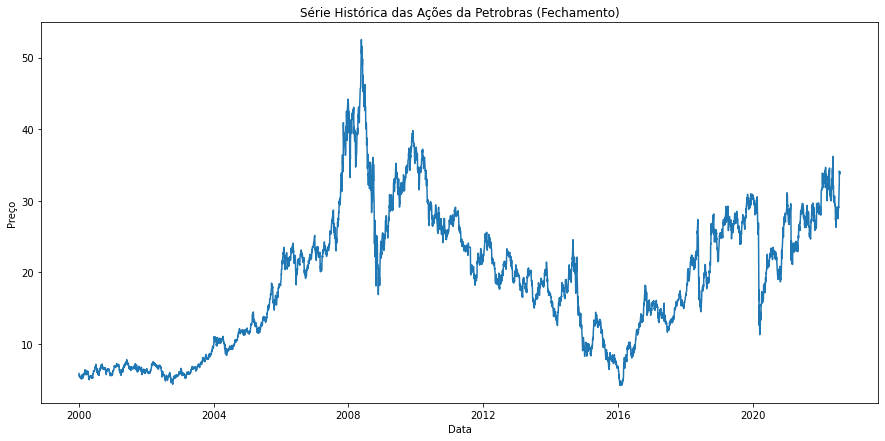

In [81]:
plt.figure(figsize=(15,7))
plt.title("Série Histórica das Ações da Petrobras (Fechamento)")
plt.xlabel('Data')
plt.ylabel('Preço')
plt.plot(df)
plt.show()

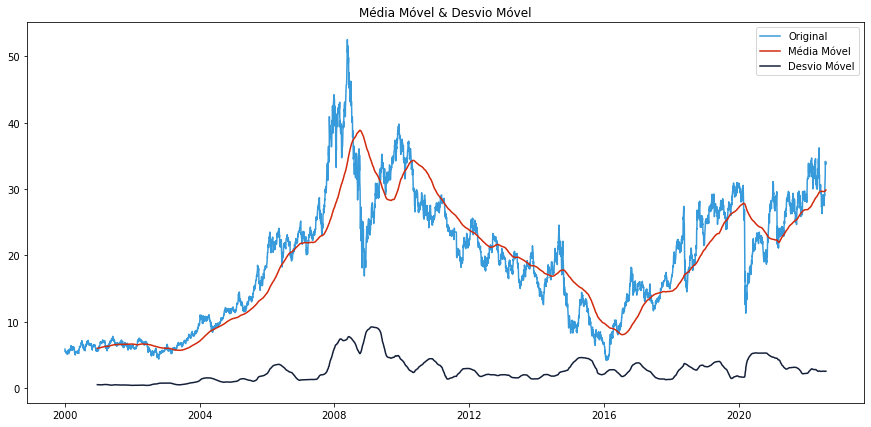

In [82]:
#Determine rolling statistics
df["rolling_avg"] = df["close"].rolling(window=252).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["close"].rolling(window=252).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["close"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Média Móvel')
plt.plot(df["rolling_std"], color='#142039', label='Desvio Móvel')
plt.legend(loc='best')
plt.title('Média Móvel & Desvio Móvel')
plt.show(block=False)

In [83]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -2.206589
p-value                           0.203863
#Lags Used                       32.000000
Number of Observations Used    5644.000000
Critical Value (1%)              -3.431509
Critical Value (5%)              -2.862052
Critical Value (10%)             -2.567043
dtype: float64


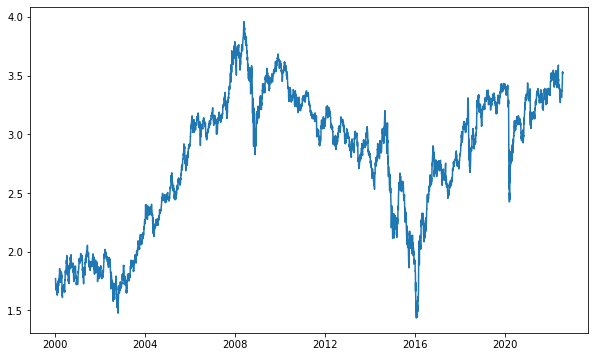

In [84]:
#Estimating trend
indexedDataset_logScale = np.log(df['close'])
plt.plot(indexedDataset_logScale)

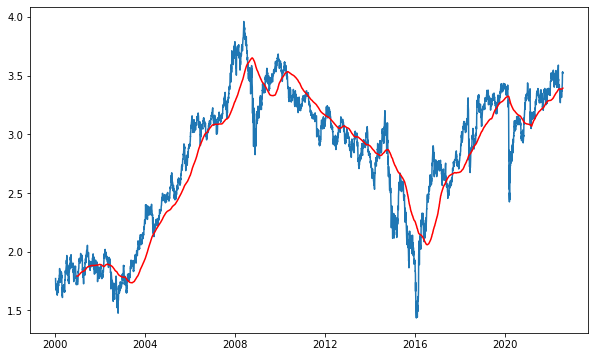

In [85]:
movingAverage = indexedDataset_logScale.rolling(window=252).mean()
movingSTD = indexedDataset_logScale.rolling(window=252).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [86]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

date
2000-12-19   -0.038040
2000-12-20   -0.055151
2000-12-21   -0.070937
2000-12-22   -0.064341
2000-12-25   -0.064449
2000-12-26   -0.071200
2000-12-27   -0.057902
2000-12-28   -0.047537
2000-12-29   -0.047706
2001-01-01   -0.047992
Name: close, dtype: float64

In [87]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(df['close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

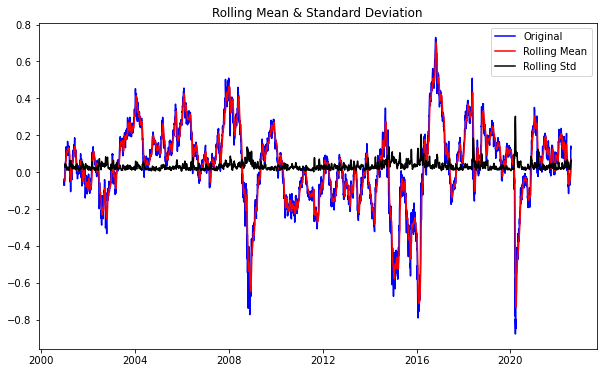

Results of Dickey Fuller Test:
Test Statistic                   -2.206589
p-value                           0.203863
#Lags Used                       32.000000
Number of Observations Used    5644.000000
Critical Value (1%)              -3.431509
Critical Value (5%)              -2.862052
Critical Value (10%)             -2.567043
dtype: float64


In [88]:
test_stationarity(datasetLogScaleMinusMovingAverage)

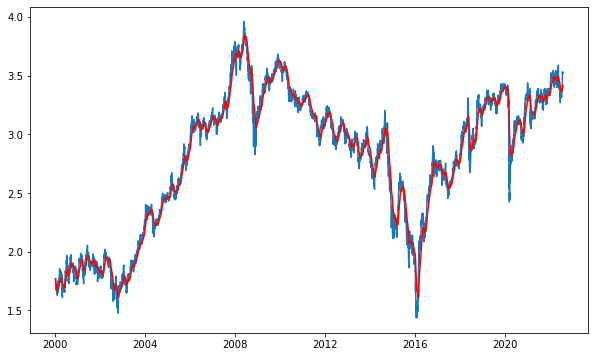

In [89]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

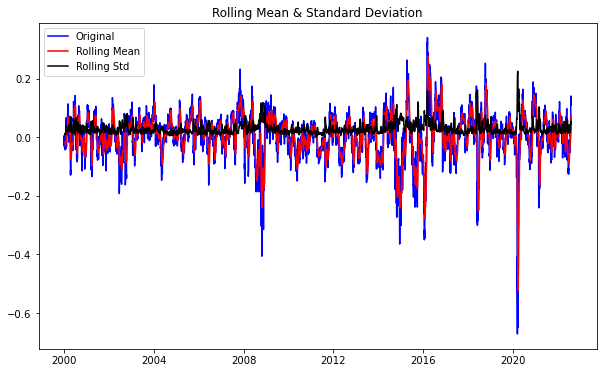

Results of Dickey Fuller Test:
Test Statistic                   -2.206589
p-value                           0.203863
#Lags Used                       32.000000
Number of Observations Used    5644.000000
Critical Value (1%)              -3.431509
Critical Value (5%)              -2.862052
Critical Value (10%)             -2.567043
dtype: float64


In [90]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

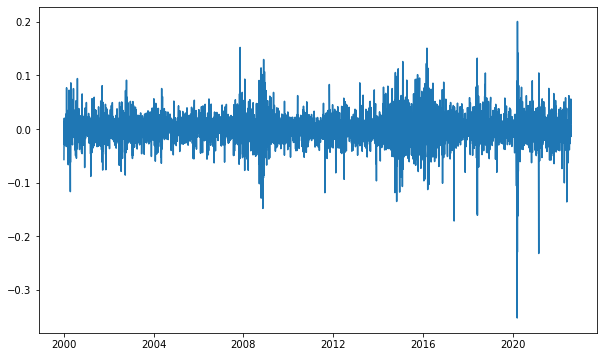

In [91]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

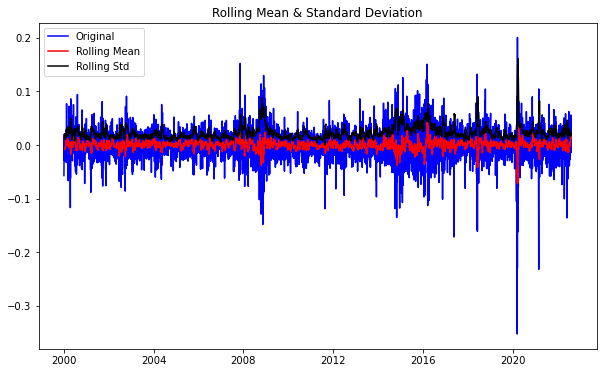

Results of Dickey Fuller Test:
Test Statistic                   -2.206589
p-value                           0.203863
#Lags Used                       32.000000
Number of Observations Used    5644.000000
Critical Value (1%)              -3.431509
Critical Value (5%)              -2.862052
Critical Value (10%)             -2.567043
dtype: float64


In [92]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [94]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [100]:
seasonal_decompose(df, model = 'additive')

ValueError: This function does not handle missing values

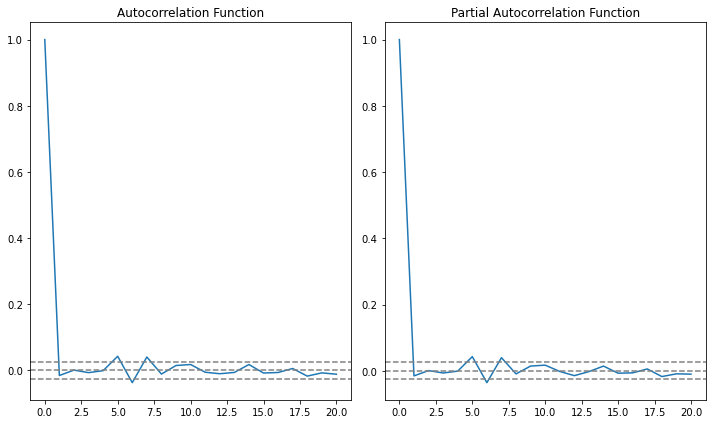

In [ ]:


#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            



In [ ]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


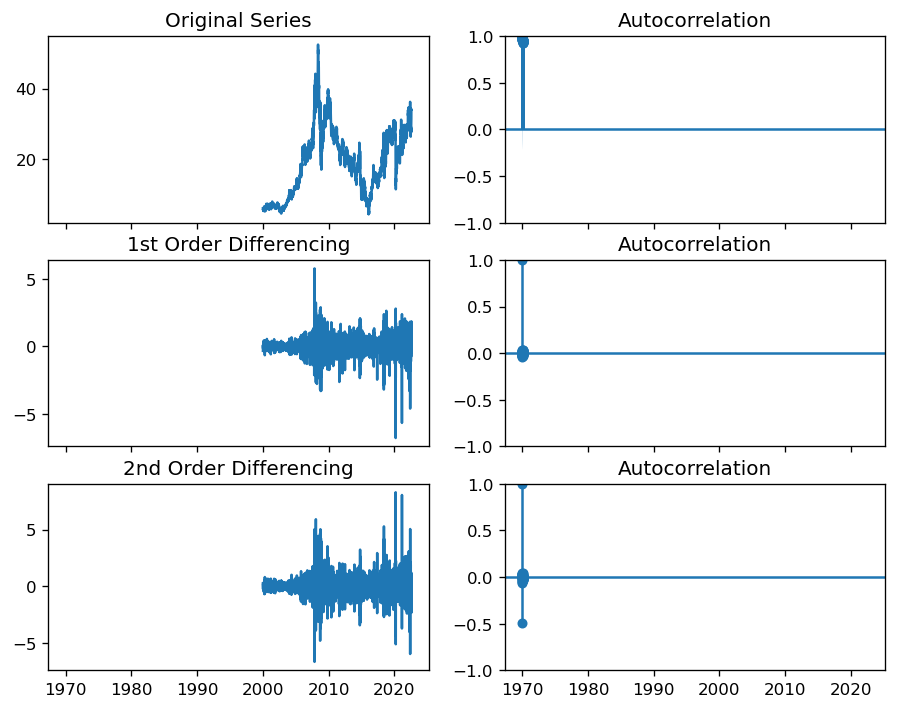

In [ ]:


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.close); axes[0, 0].set_title('Original Series')
plot_acf(df.close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

